# Relationship between roads and minor LULC classes of grass

- Load road network and LULC files
- Buffer road network
- Spatial Join by Intersection LULC to road network 
- Calculate pivot tables per road types and minor LULC classes of grass

In [2]:
import yaml
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr

crs = 25832

sns.set_theme(style='ticks')
sns.set_context('paper')

plt.rcParams['font.size'] = 12  # Adjust base font size as needed
plt.rcParams['axes.labelsize'] = 12  # For x and y labels
plt.rcParams['axes.titlesize'] = 12  # For subplot titles
plt.rcParams['xtick.labelsize'] = 12  # For x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # For y-axis tick labels

data_dir = Path('../data')
ca_lulc_dir = Path('../../lulc-utility')
out_dir = Path('../outdir')

In [3]:
cmap_diverging = 'BrBG'
colors = plt.get_cmap(cmap_diverging)(np.linspace(0.5, 1.0,  plt.get_cmap(cmap_diverging).N // 2))
cmap_sequential = LinearSegmentedColormap.from_list('my_sequential', colors)

In [53]:
road_network = gpd.read_feather(out_dir / 'preprocessed_road_network.feather')
lana = gpd.read_feather(out_dir / 'preprocessed_lulc.feather')

In [54]:
road_network['highway'].value_counts().sort_index()

highway
cycleway           893
footway          27441
living_street     2610
motorway           792
motorway_link      583
path             15905
pedestrian         457
primary           3053
residential      18074
secondary         4812
service          29207
tertiary          4370
track            23176
trunk              463
trunk_link         388
unclassified      2530
Name: count, dtype: int64

LULC tags

In [97]:
with open(ca_lulc_dir / 'data' / 'label' / 'label_v3.yaml') as file:
    osm_filters = yaml.safe_load(file)
osm_filters

[{'name': 'built-up',
  'osm_filter': 'landuse=civic_admin or landuse=commercial or landuse=depot or landuse=education or landuse=farmyard or landuse=garages or landuse=industrial or landuse=railway or landuse=residential or landuse=retail',
  'color_code': '#ff0000',
  'description': 'This class is a combination of land-use classes that should consist of mostly built-up land cover.'},
 {'name': 'forest',
  'osm_filter': 'landuse=forest or natural=wood',
  'color_code': '#4dc800',
  'description': 'Managed and unmanaged tree covers.'},
 {'name': 'water',
  'osm_filter': 'landuse=reservoir or natural=water or waterway=dock or waterway=riverbank',
  'color_code': '#82c8fa',
  'description': None},
 {'name': 'farmland',
  'osm_filter': 'landuse=farmland',
  'color_code': '#ffff50',
  'description': 'Agricultural land that is regularly tilled.'},
 {'name': 'permanent_crops',
  'osm_filter': 'landuse=vineyard or landuse=orchard',
  'color_code': '#e68000',
  'description': None},
 {'name': 

## Preprocess data

Reproject

In [55]:
road_network.to_crs(crs, inplace=True)
lana.to_crs(crs, inplace=True)

Calculate road lengths

In [56]:
road_network['road_length'] = round(road_network['geometry'].length, 2)

In [57]:
f'{round(road_network["road_length"].sum() / 1000, 2)} km'

'17606.58 km'

Combine minor LULC classes in new col 'lana'

In [58]:
# Define a function to apply to each row with shortened column names
def determine_lana_shortened(row):
    # Mapping of original column names to their shortened forms
    col_mapping = {'landuse': 'l', 'waterway': 'w', 'natural': 'n'}
    # Initialize an empty list to hold the column-value pairs
    col_val_pairs = []
    
    # Iterate over the specified columns in the mapping
    for col, short_col in col_mapping.items():
        # Check if the column is not NaN
        if pd.notna(row[col]):
            # Append the shortened column name and value in the format "shortcolumnname_value"
            col_val_pairs.append(f"{short_col}_{row[col]}")
    
    # If only one column is filled, or multiple, return the concatenated string
    return '_'.join(col_val_pairs) if col_val_pairs else pd.NA

# Apply the function to each row and create the 'lana' column with shortened names
lana['lana'] = lana.apply(determine_lana_shortened, axis=1)

In [59]:
# Display the DataFrame to verify the new 'lana' column
lana['lana'].value_counts()

lana
l_meadow                   8603
l_farmland                 8218
l_grass                    5595
n_wood                     2082
l_orchard                  1795
l_forest                   1092
n_water                    1067
l_vineyard                  954
l_farmyard                  659
l_residential               650
l_industrial                436
l_commercial                335
l_railway                   330
n_grassland                 314
l_retail                    146
l_garages                    38
l_reservoir                  21
l_education                  20
l_aquaculture_n_water        18
l_forest_n_wood              10
l_grass_n_scrub               9
l_forest_n_scrub              5
l_meadow_n_scrub              3
l_reservoir_n_water           2
l_basin_n_water               2
l_grass_n_grassland           2
l_orchard_n_scrub             1
l_commercial_w_boatyard       1
l_civic_admin                 1
l_meadow_n_grass              1
Name: count, dtype: int64

In [60]:
lana.drop(columns=['landuse', 'waterway', 'natural'], inplace=True)

Buffer road network

In [62]:
road_network_10 = road_network.copy()
road_network_10['geometry'] = road_network_10['geometry'].buffer(10)
road_network_25 = road_network.copy()
road_network_25['geometry'] = road_network_25['geometry'].buffer(25)

## Statistical relationship: intersect LULC classes by road network and compare lengths and proportions

### Preprocess calculations

Intersect road network with LULC

In [63]:
lana_roads = gpd.sjoin(road_network, lana, how='inner', predicate='intersects')
lana_roads_10 = gpd.sjoin(road_network_10, lana, how='inner', predicate='intersects')
lana_roads_25 = gpd.sjoin(road_network_25, lana, how='inner', predicate='intersects')

Save intersected road files as feather and load again

In [64]:
lana_roads.to_feather(out_dir / 'lana_roads.feather')
lana_roads_10.to_feather(out_dir / 'lana_roads_10.feather')
lana_roads_25.to_feather(out_dir / 'lana_roads_25.feather')

In [4]:
lana_roads = gpd.read_feather(out_dir / 'lana_roads.feather')
lana_roads_10 = gpd.read_feather(out_dir / 'lana_roads_10.feather')
lana_roads_25 = gpd.read_feather(out_dir / 'lana_roads_25.feather')

Calculate total road length for each minor LULC class

In [5]:
road_length_by_lana = lana_roads.groupby('lana')['road_length'].sum()
road_length_by_lana_10 = lana_roads_10.groupby('lana')['road_length'].sum()
road_length_by_lana_25 = lana_roads_25.groupby('lana')['road_length'].sum()

In [6]:
round(road_length_by_lana.unique().sum() / 1000, 2), round(road_length_by_lana_10.unique().sum() / 1000, 2), round(road_length_by_lana_25.unique().sum() / 1000, 2)

(24896.32, 54410.24, 70886.5)

Aggregate total road lengths by road type for each LULC class

In [7]:
lana_pivot = lana_roads.pivot_table(index='highway', columns='lana', values='road_length', aggfunc='sum', fill_value=0)
lana_pivot_10 = lana_roads_10.pivot_table(index='highway', columns='lana', values='road_length', aggfunc='sum', fill_value=0)
lana_pivot_25 = lana_roads_25.pivot_table(index='highway', columns='lana', values='road_length', aggfunc='sum', fill_value=0)

In [8]:
all_columns = set(lana_pivot.columns) | set(lana_pivot_10.columns) | set(lana_pivot_25.columns)

lana_pivot = lana_pivot.reindex(columns=all_columns, fill_value=0)
lana_pivot_10 = lana_pivot_10.reindex(columns=all_columns, fill_value=0)
lana_pivot_25 = lana_pivot_25.reindex(columns=all_columns, fill_value=0)

### Road Types per minor LULC Class

Proportion of each road type per LULC class (Vertical 100 %)

In [9]:
lana_pivot_percent_lana = lana_pivot.divide(lana_pivot.sum(axis=0), axis=1) * 100
lana_pivot_percent_lana_10 = lana_pivot_10.divide(lana_pivot_10.sum(axis=0), axis=1) * 100
lana_pivot_percent_lana_25 = lana_pivot_25.divide(lana_pivot_25.sum(axis=0), axis=1) * 100

lana_pivot_percent_lana = lana_pivot_percent_lana[sorted(lana_pivot_percent_lana.columns)]
lana_pivot_percent_lana_10 = lana_pivot_percent_lana_10[sorted(lana_pivot_percent_lana_10.columns)]
lana_pivot_percent_lana_25 = lana_pivot_percent_lana_25[sorted(lana_pivot_percent_lana_25.columns)]

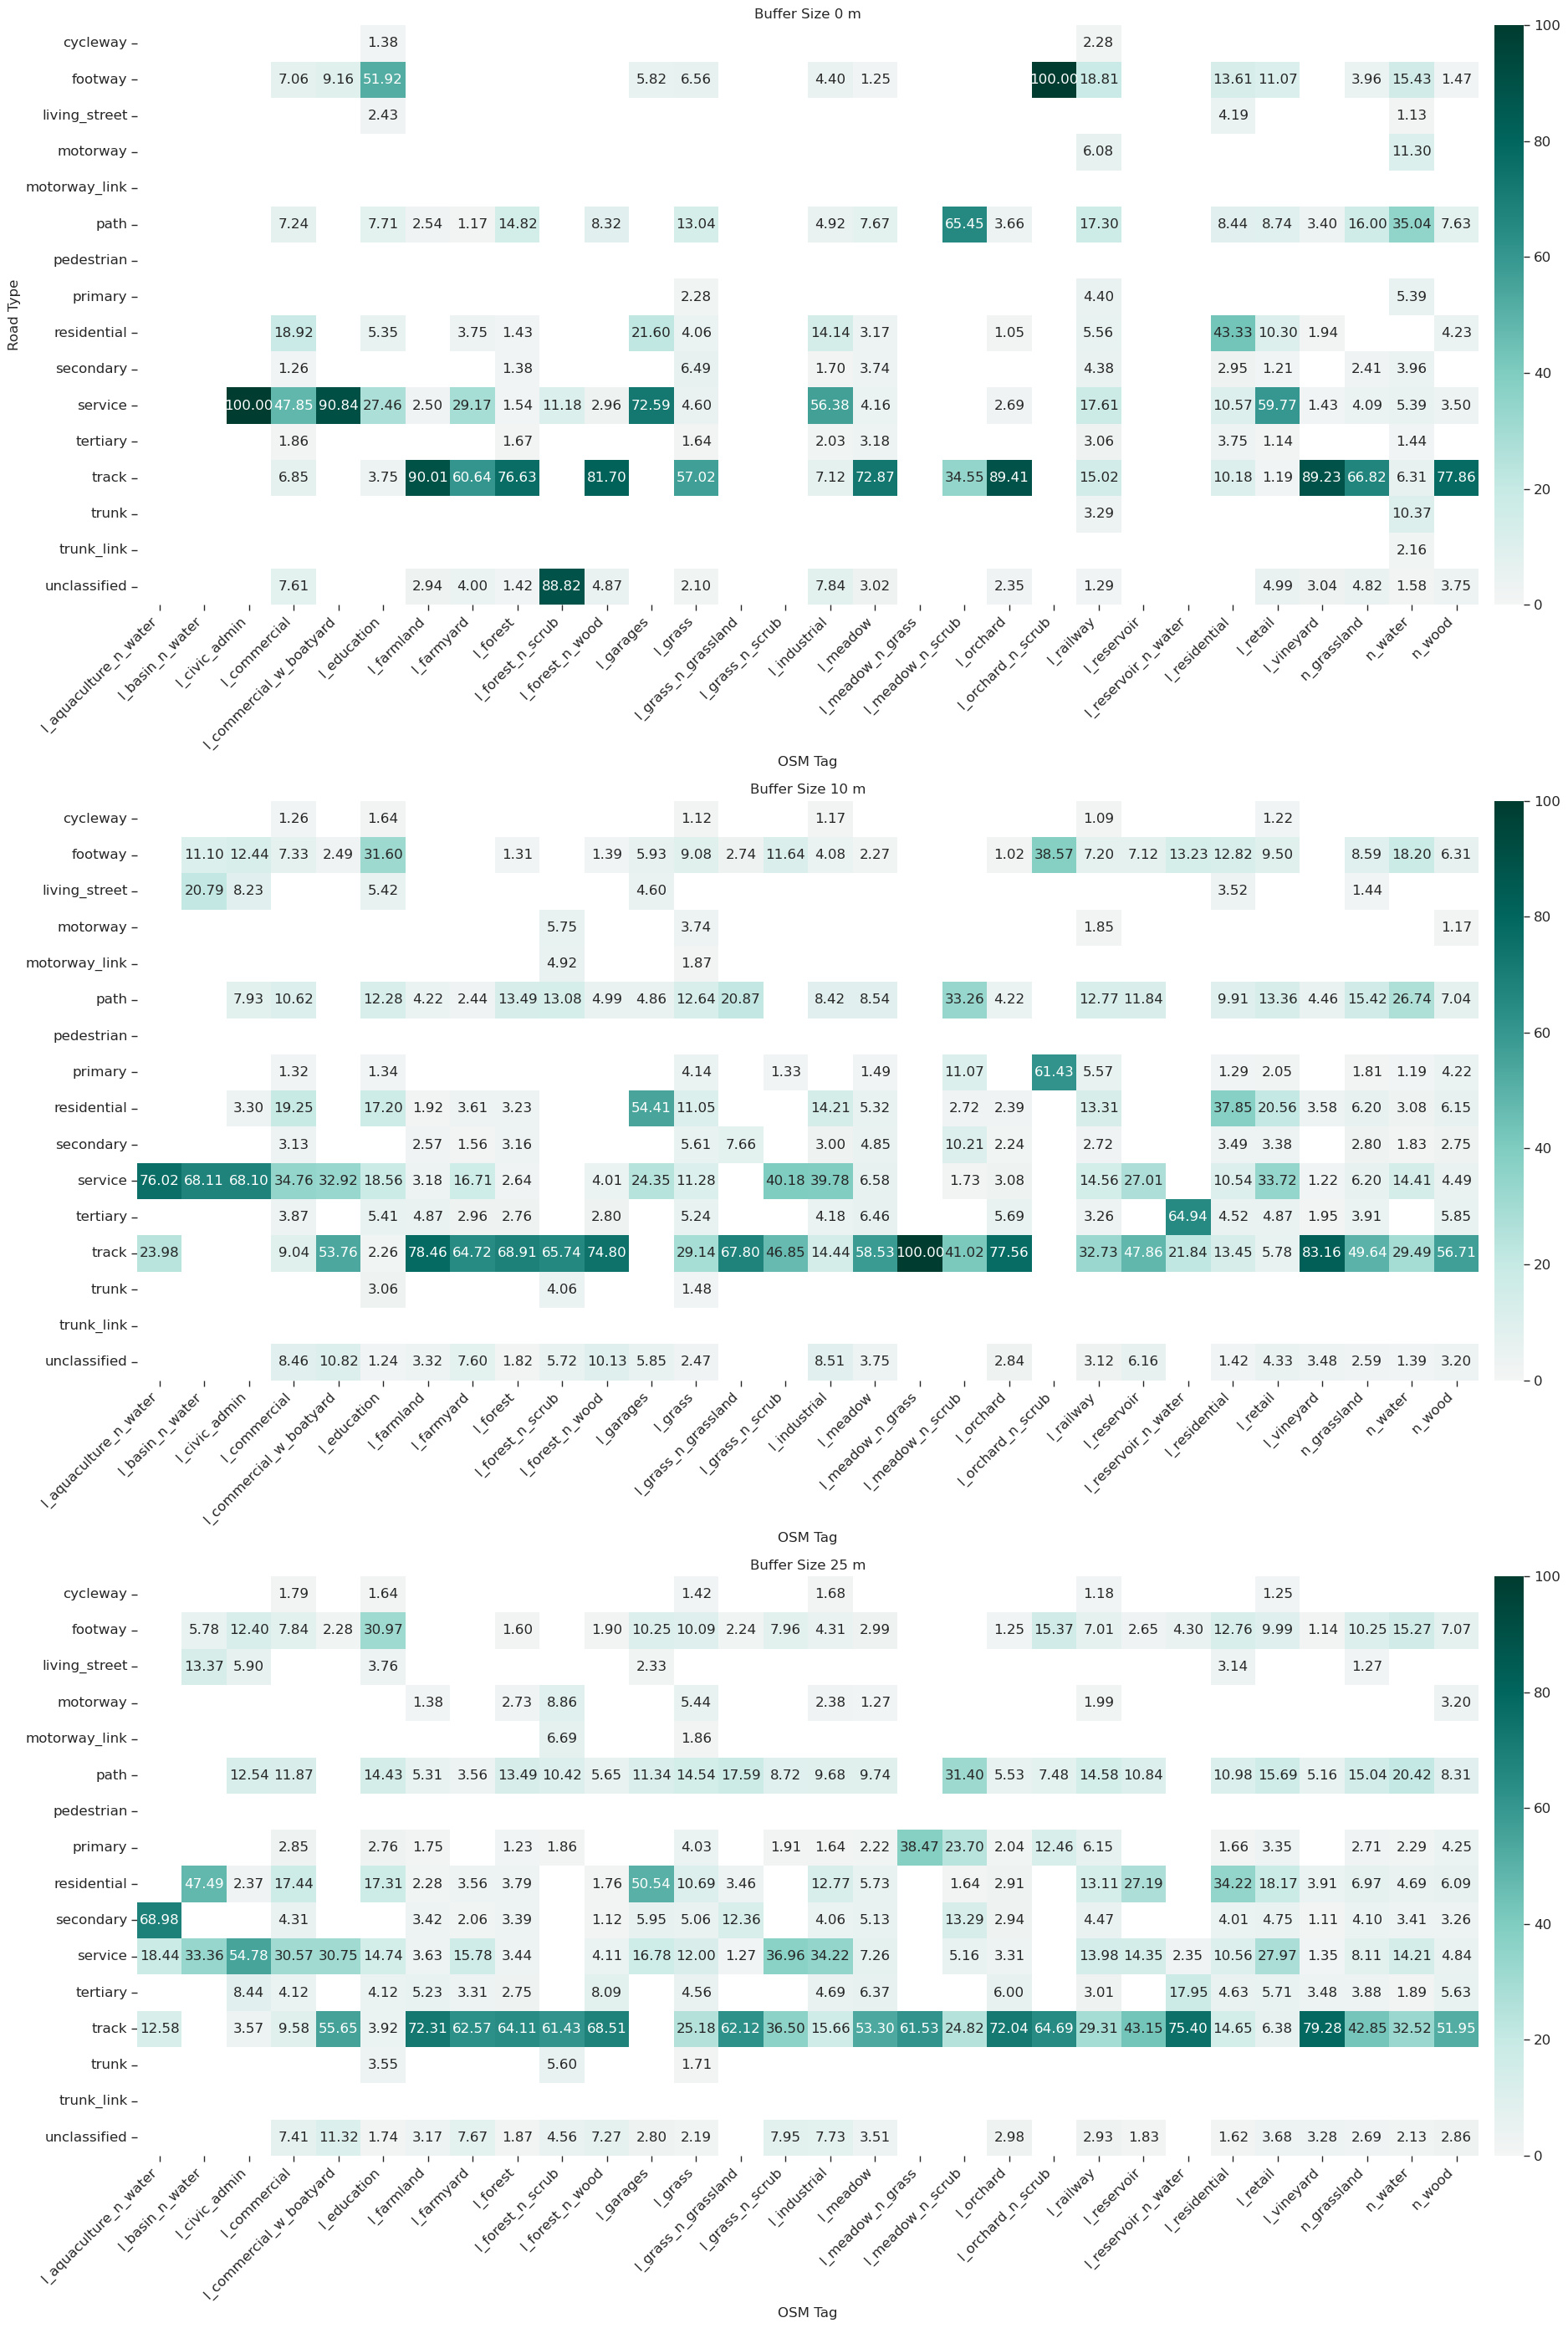

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(21, 28))

vmin=0
vmax=100

mask_lana_mean = lana_pivot_percent_lana < 1
mask_lana_mean_10 = lana_pivot_percent_lana_10 < 1
mask_lana_mean_25 = lana_pivot_percent_lana_25 < 1

sns.heatmap(lana_pivot_percent_lana, mask=mask_lana_mean, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01}, ax=axs[0])
axs[0].set_title('Buffer Size 0 m')
axs[0].set_ylabel('Road Type')
axs[0].set_xlabel('OSM Tag')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(lana_pivot_percent_lana_10, mask=mask_lana_mean_10, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01}, ax=axs[1])
axs[1].set_title('Buffer Size 10 m')
axs[1].set_ylabel('')
axs[1].set_xlabel('OSM Tag')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(lana_pivot_percent_lana_25, mask=mask_lana_mean_25, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01}, ax=axs[2])
axs[2].set_title('Buffer Size 25 m')
axs[2].set_ylabel('')
axs[2].set_xlabel('OSM Tag')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')

# plt.savefig(out_dir / 'road_types_lana_vertical.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

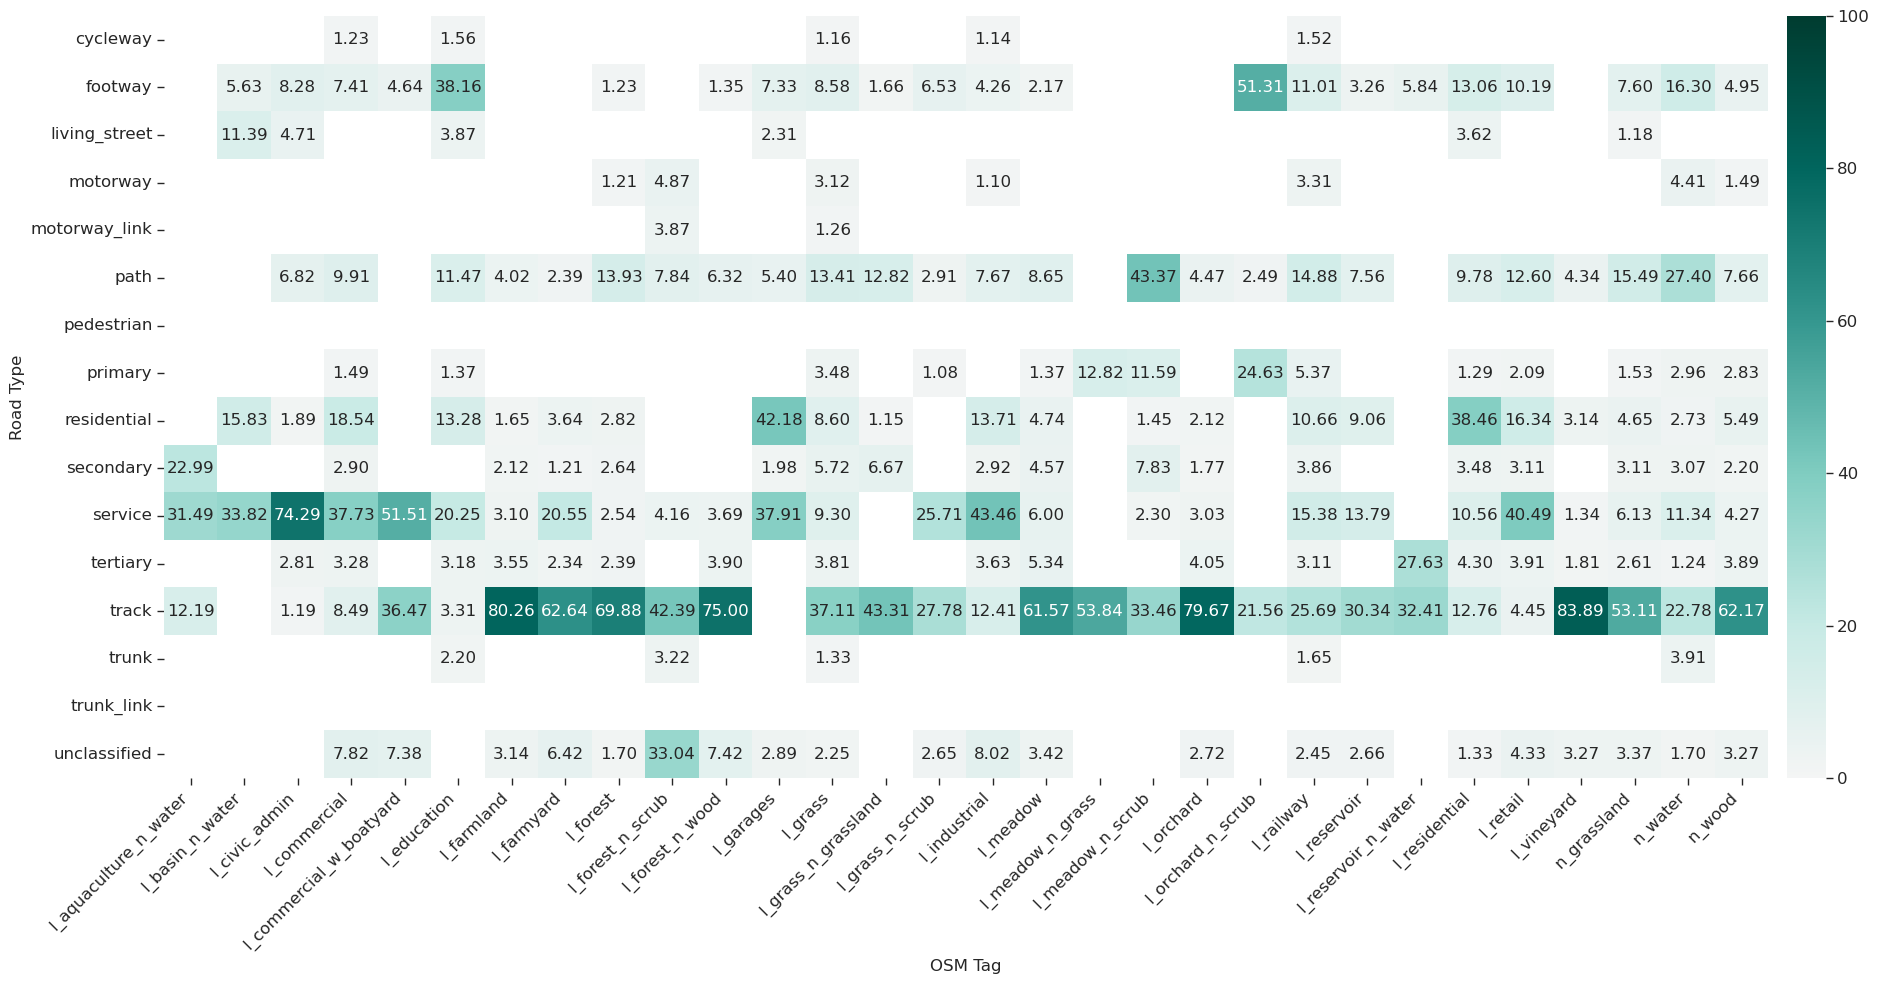

In [11]:
lana_pivot_percent_lana_mean = (lana_pivot_percent_lana.add(lana_pivot_percent_lana_10, fill_value=0).add(lana_pivot_percent_lana_25, fill_value=0)) / 3

fig, ax = plt.subplots(figsize=(21, 10))

mask_roads_mean = lana_pivot_percent_lana_mean < 1

sns.heatmap(lana_pivot_percent_lana_mean, mask=mask_roads_mean, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=0, vmax=100, cbar_kws={'pad': 0.01}, ax=ax)
ax.set_ylabel('Road Type')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel('OSM Tag')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Calculate differences between buffer sizes

In [12]:
diff_0_to_10_lulc = lana_pivot_percent_lana_10 - lana_pivot_percent_lana
diff_10_to_25_lulc = lana_pivot_percent_lana_25 - lana_pivot_percent_lana_10
diff_0_to_25_lulc = lana_pivot_percent_lana_25 - lana_pivot_percent_lana

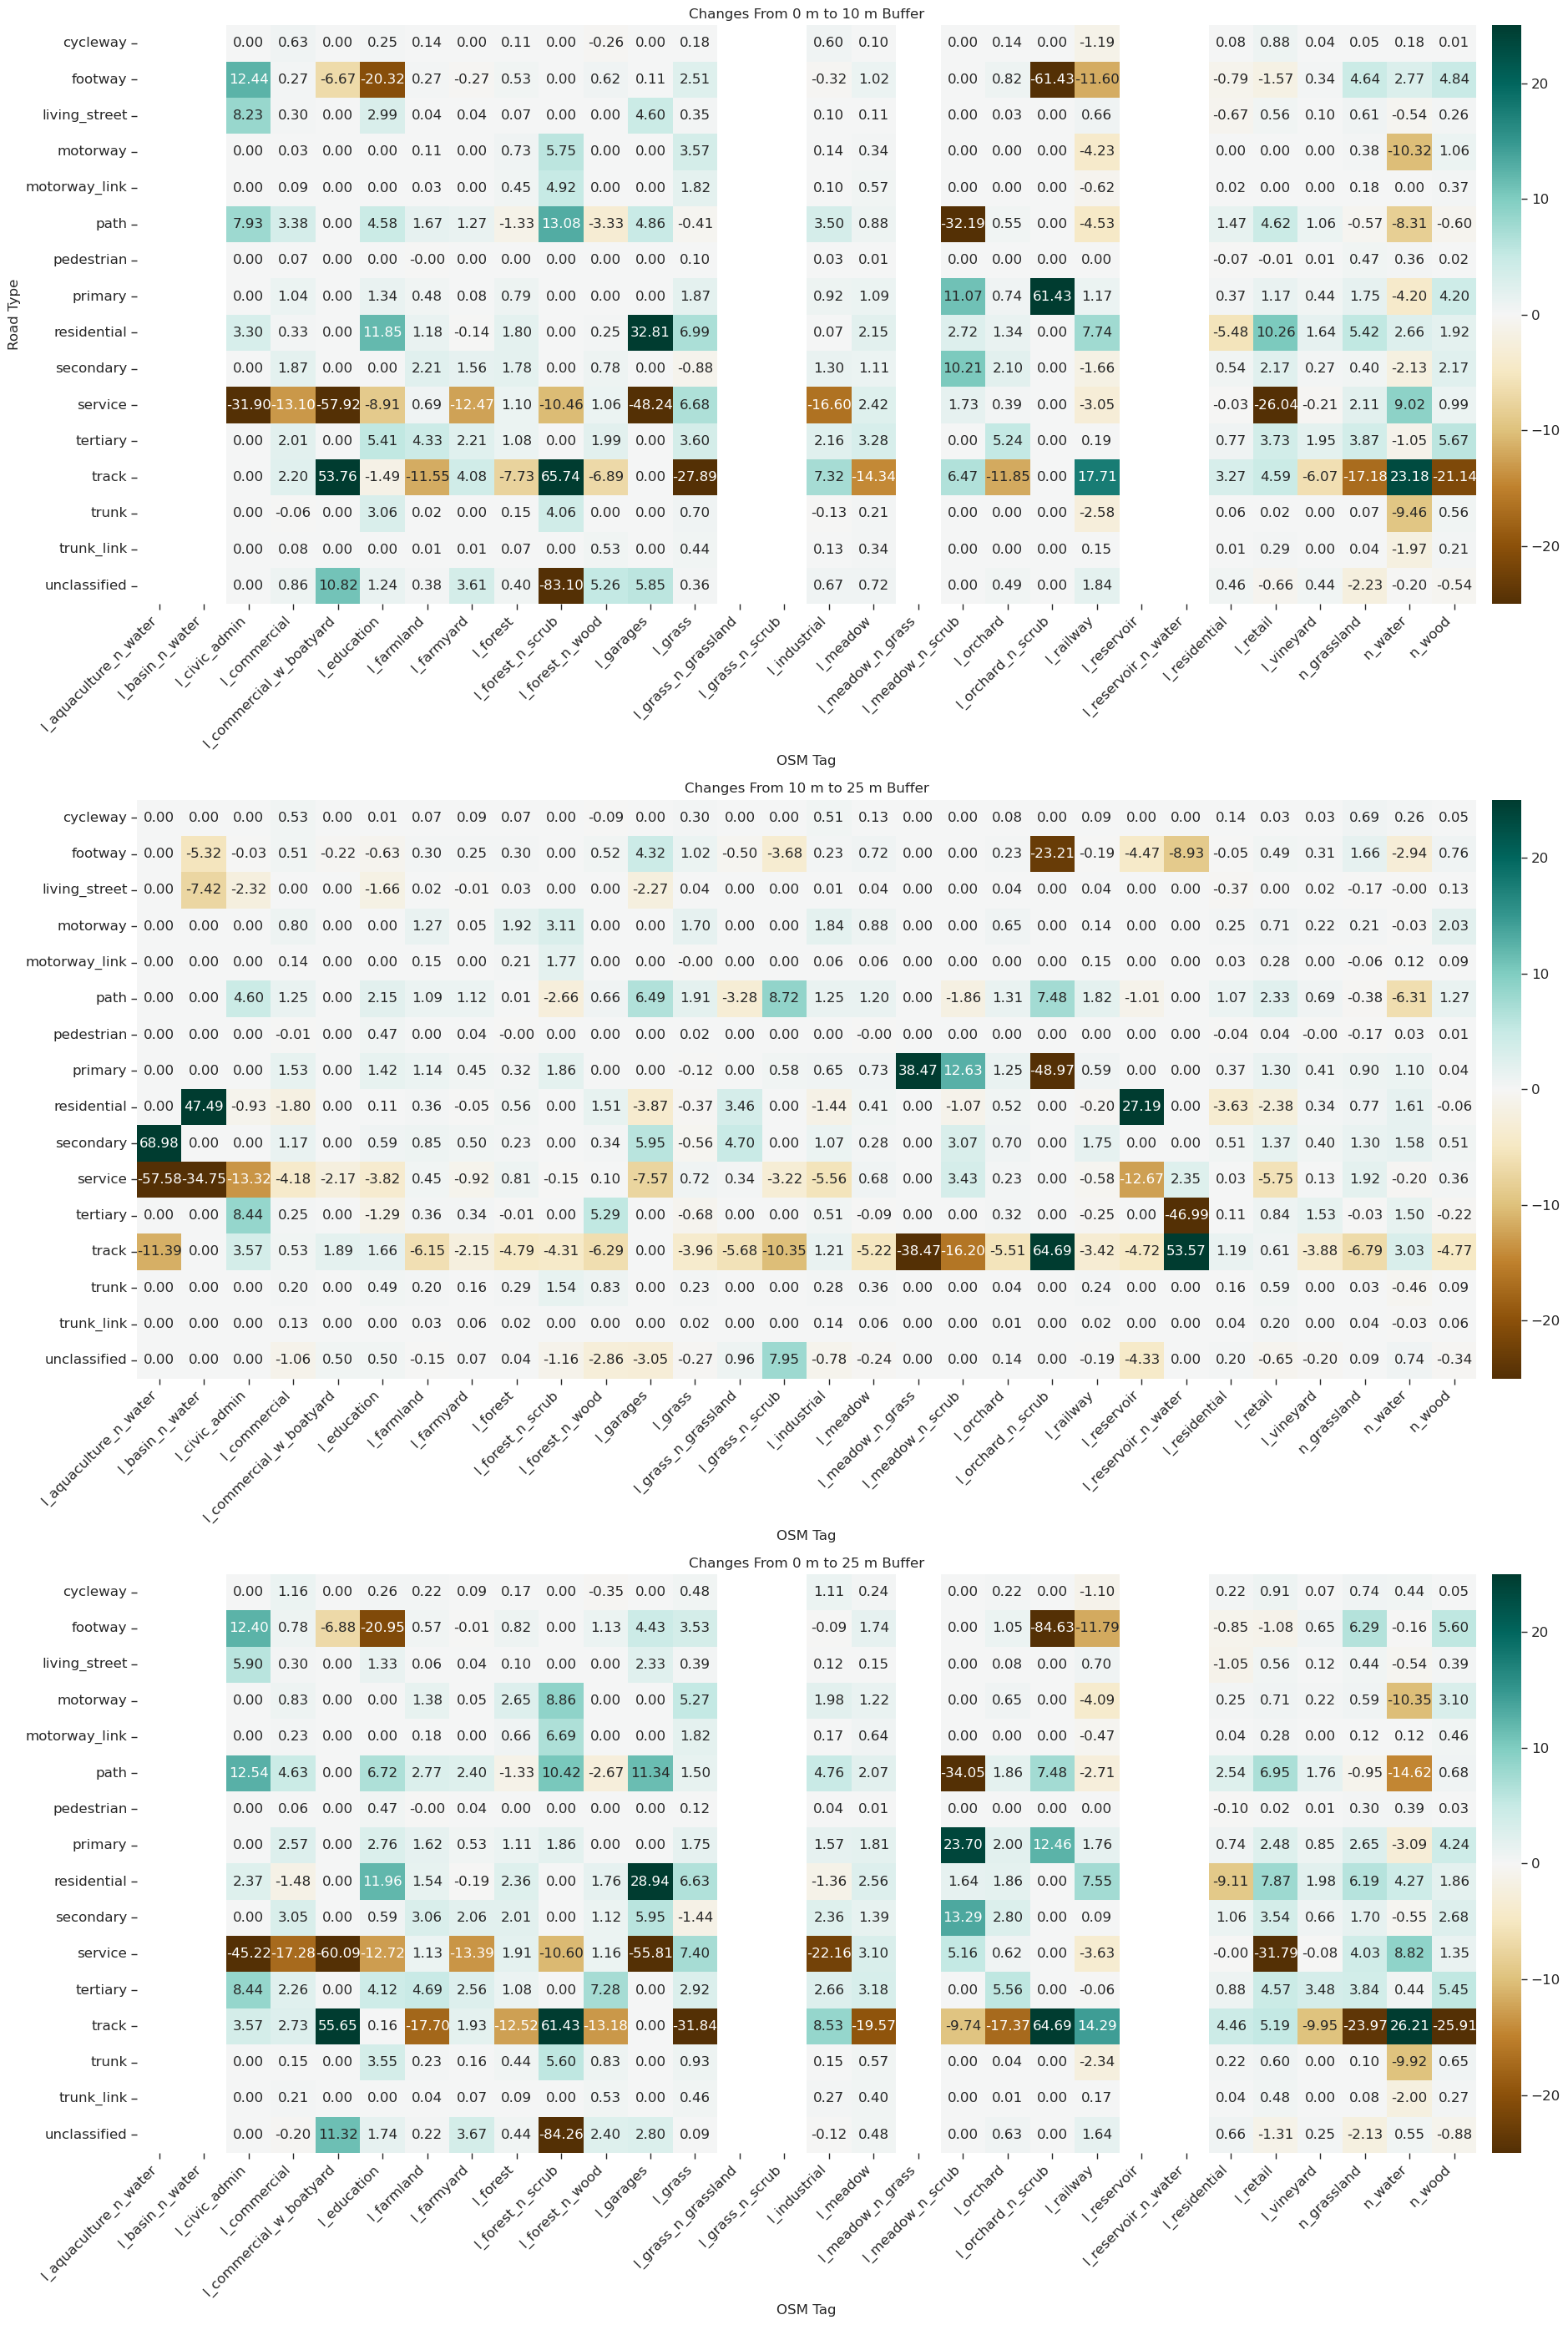

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(21, 28))

vmin=-25
vmax=25

# Difference from 0m to 10m
sns.heatmap(diff_0_to_10_lulc, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01}, ax=axs[0])
axs[0].set_title('Changes From 0 m to 10 m Buffer')
axs[0].set_ylabel('Road Type')
axs[0].set_xlabel('OSM Tag')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

# Difference from 10m to 25m
sns.heatmap(diff_10_to_25_lulc, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01}, ax=axs[1])
axs[1].set_title('Changes From 10 m to 25 m Buffer')
axs[1].set_ylabel('')
axs[1].set_xlabel('OSM Tag')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

# Difference from 0m to 25m
sns.heatmap(diff_0_to_25_lulc, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01}, ax=axs[2])
axs[2].set_title('Changes From 0 m to 25 m Buffer')
axs[2].set_ylabel('')
axs[2].set_xlabel('OSM Tag')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')

# plt.savefig(out_dir / 'road_types_lana_vertical_changes.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

### LULC Classes per Road Types

Proportion of a road type belonging to each LULC class (Horizontal 100 %)

In [14]:
lana_pivot_percent_roads = lana_pivot.divide(lana_pivot.sum(axis=1), axis=0) * 100
lana_pivot_percent_roads_10 = lana_pivot_10.divide(lana_pivot_10.sum(axis=1), axis=0) * 100
lana_pivot_percent_roads_25 = lana_pivot_25.divide(lana_pivot_25.sum(axis=1), axis=0) * 100

lana_pivot_percent_roads = lana_pivot_percent_roads[sorted(lana_pivot_percent_roads.columns)]
lana_pivot_percent_roads_10 = lana_pivot_percent_roads_10[sorted(lana_pivot_percent_roads_10.columns)]
lana_pivot_percent_roads_25 = lana_pivot_percent_roads_25[sorted(lana_pivot_percent_roads_25.columns)]

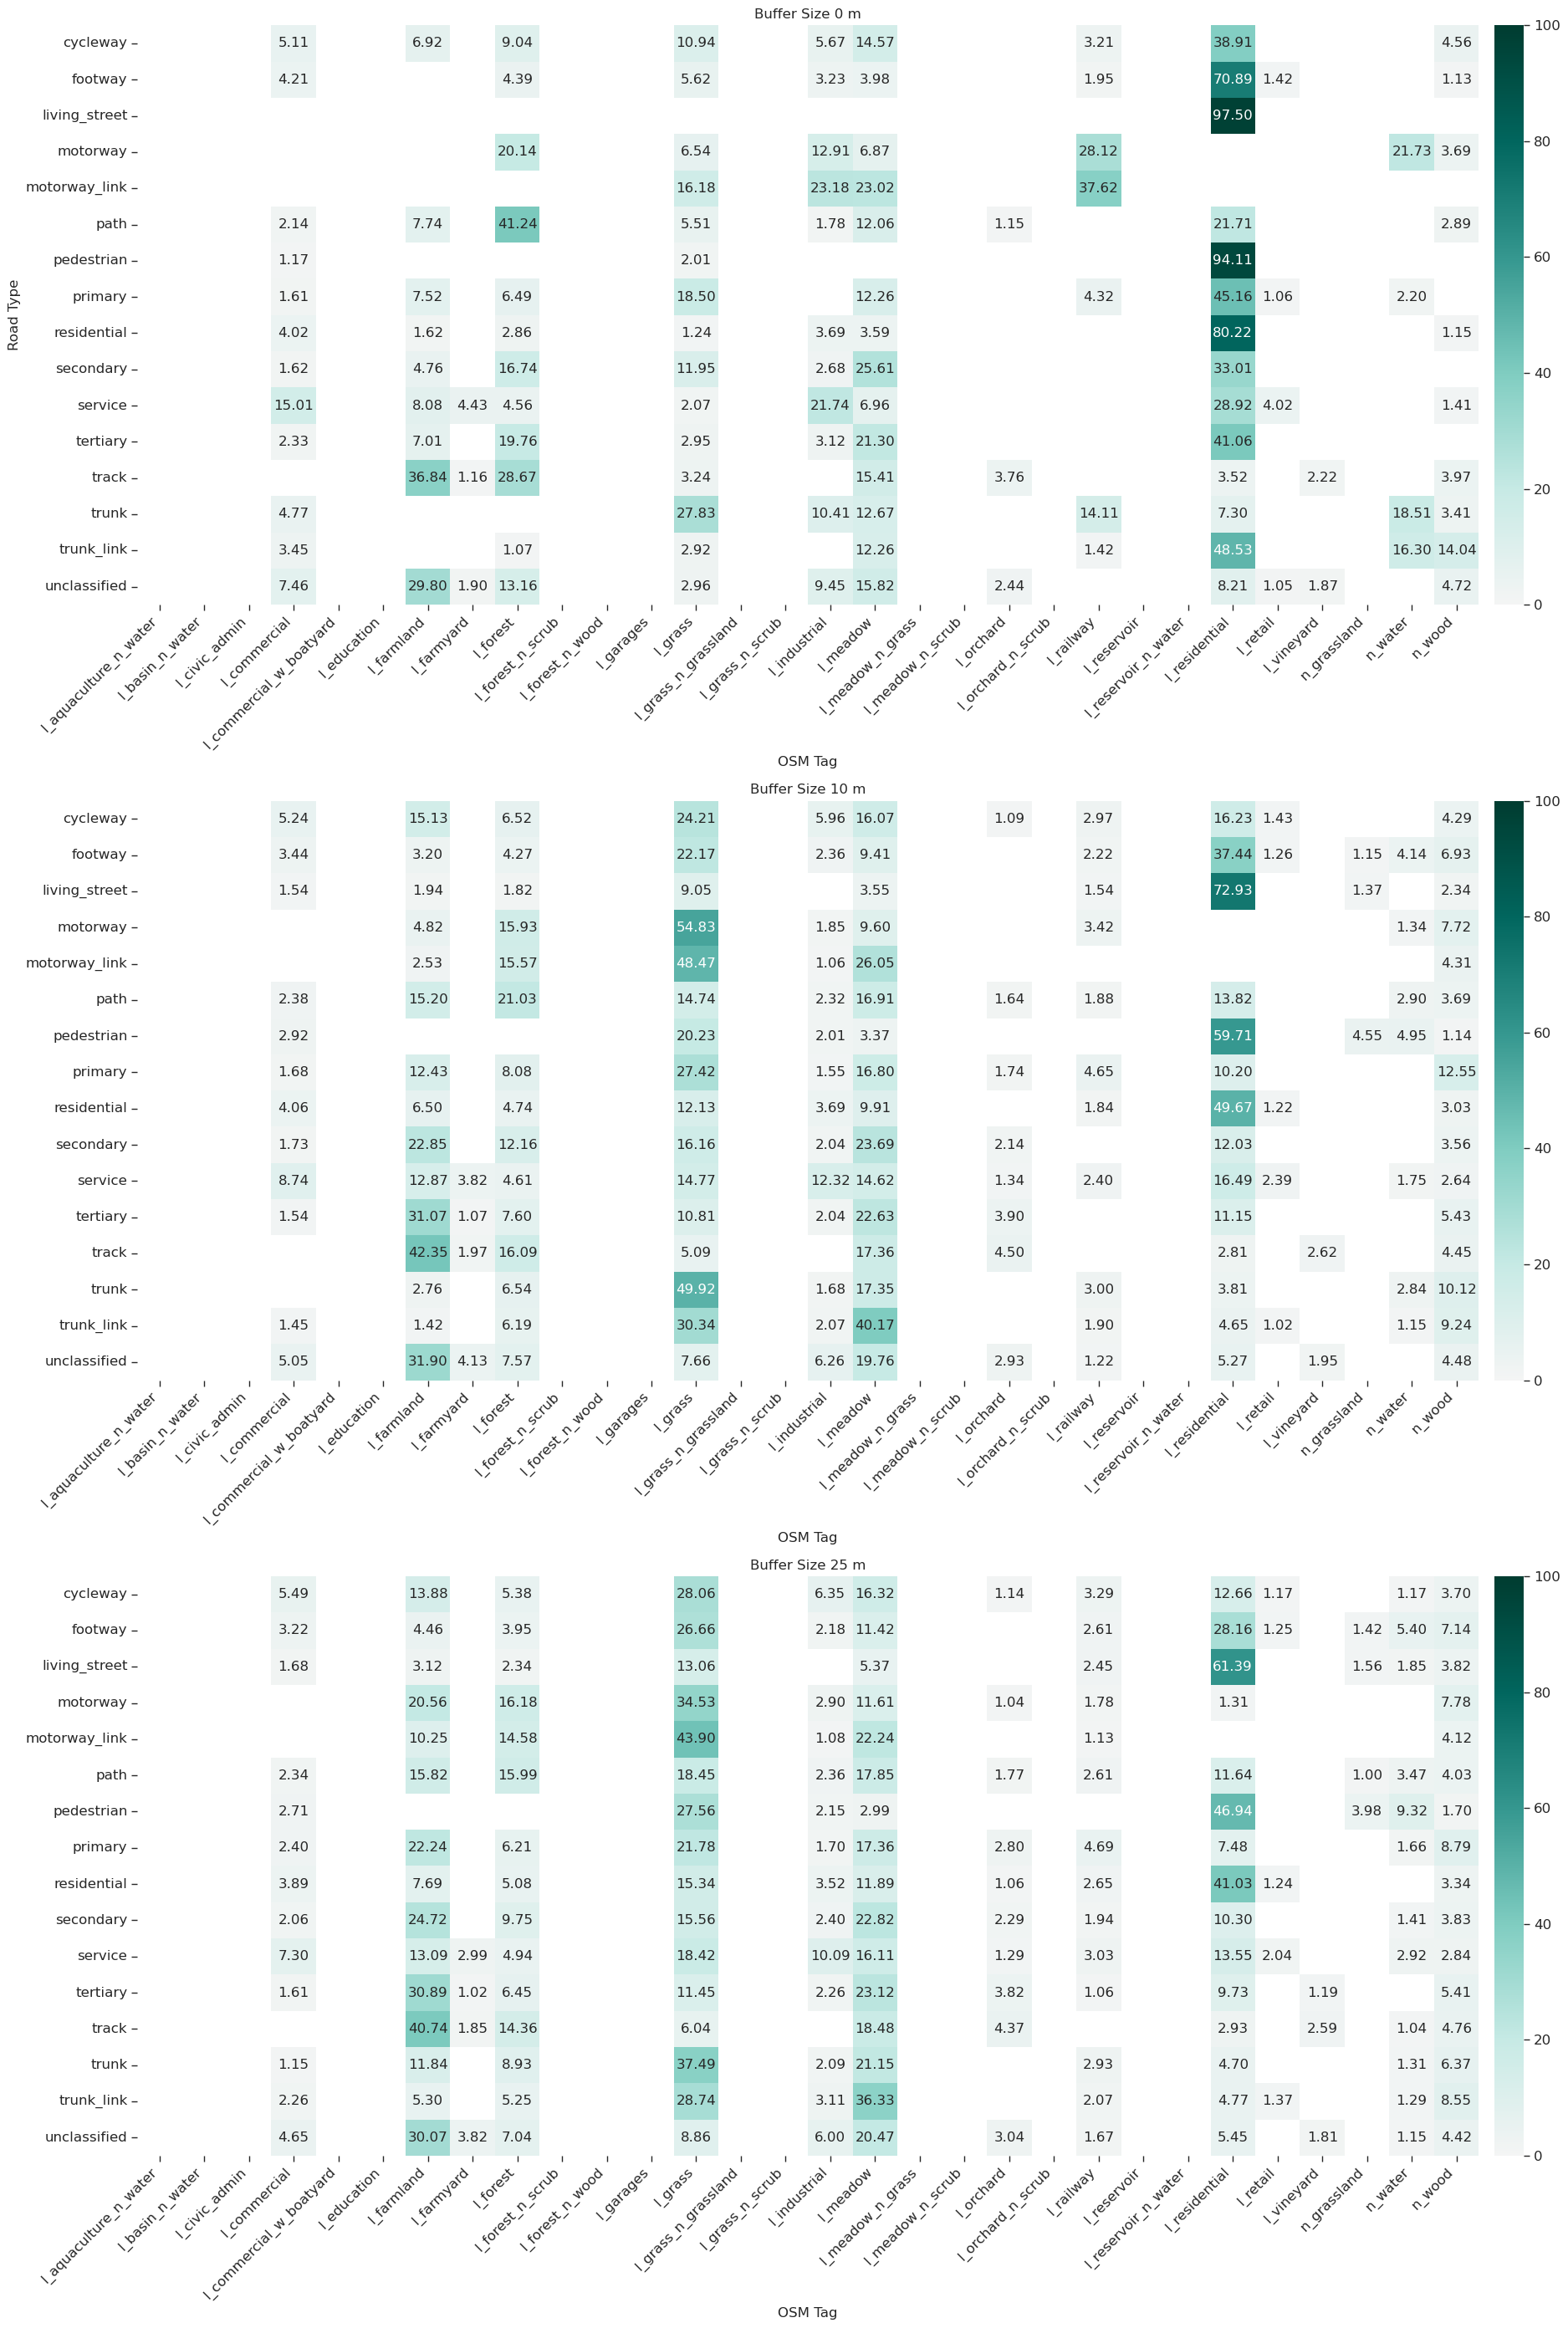

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(21, 28))

vmin=0
vmax=100

mask_roads_mean = lana_pivot_percent_roads < 1
mask_roads_mean_10 = lana_pivot_percent_roads_10 < 1
mask_roads_mean_25 = lana_pivot_percent_roads_25 < 1

sns.heatmap(lana_pivot_percent_roads, mask=mask_roads_mean, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01},  ax=axs[0])
axs[0].set_title('Buffer Size 0 m')
axs[0].set_ylabel('Road Type')
axs[0].set_xlabel('OSM Tag')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(lana_pivot_percent_roads_10, mask=mask_roads_mean_10, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01},  ax=axs[1])
axs[1].set_title('Buffer Size 10 m')
axs[1].set_ylabel('')
axs[1].set_xlabel('OSM Tag')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(lana_pivot_percent_roads_25, mask=mask_roads_mean_25, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01},  ax=axs[2])
axs[2].set_title('Buffer Size 25 m')
axs[2].set_ylabel('')
axs[2].set_xlabel('OSM Tag')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')

# plt.savefig(out_dir / 'road_types_lana_horizontal.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

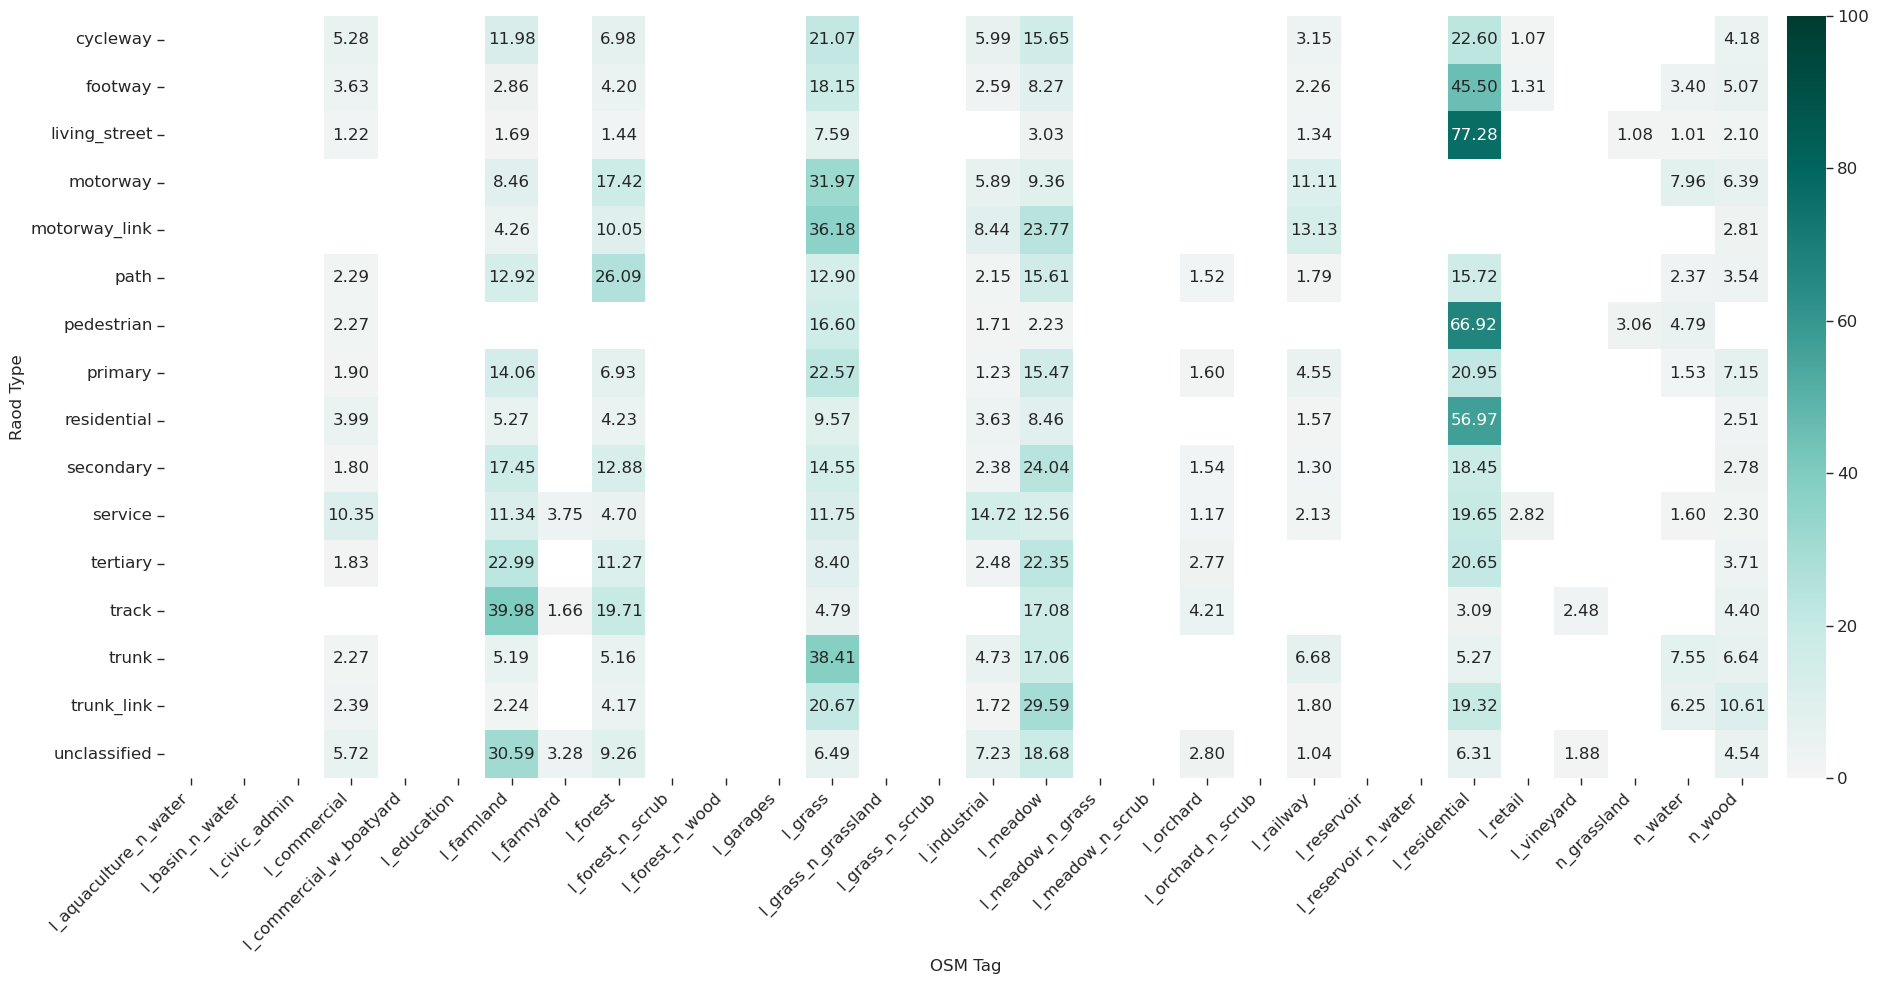

In [22]:
lana_pivot_percent_roads_mean = (lana_pivot_percent_roads.add(lana_pivot_percent_roads_10, fill_value=0).add(lana_pivot_percent_roads_25, fill_value=0)) / 3


fig, ax = plt.subplots(figsize=(21, 10))

mask_roads_mean = lana_pivot_percent_roads_mean < 1

sns.heatmap(lana_pivot_percent_roads_mean, mask=mask_roads_mean, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=0, vmax=100, cbar_kws={'pad': 0.01},  ax=ax)
ax.set_ylabel('Raod Type')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel('OSM Tag')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

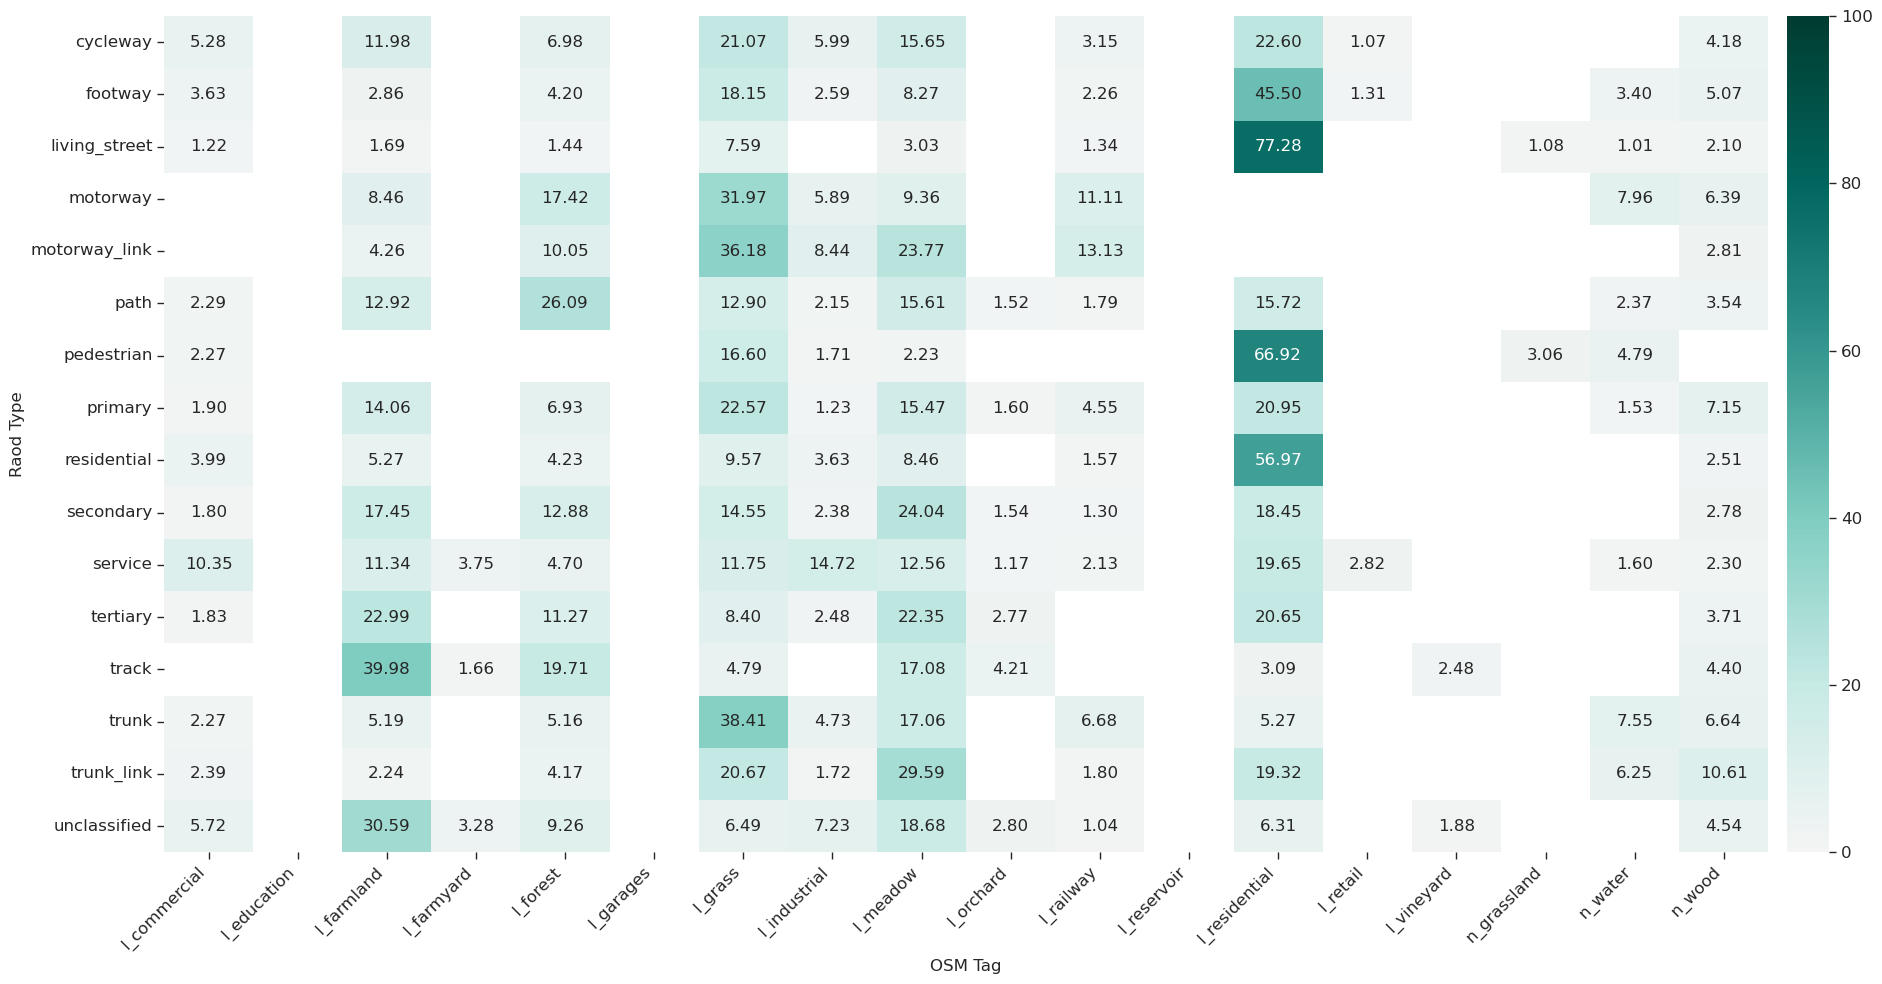

In [23]:
lana_pivot_percent_roads_mean = (lana_pivot_percent_roads.add(lana_pivot_percent_roads_10, fill_value=0).add(lana_pivot_percent_roads_25, fill_value=0)) / 3

filtered_cols = [col for col in lana_pivot_percent_roads_mean.columns if col.count('_') < 2]
lana_pivot_percent_roads_mean = lana_pivot_percent_roads_mean[filtered_cols]

fig, ax = plt.subplots(figsize=(21, 10))

mask_roads_mean = lana_pivot_percent_roads_mean < 1

sns.heatmap(lana_pivot_percent_roads_mean, mask=mask_roads_mean, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=0, vmax=100, cbar_kws={'pad': 0.01},  ax=ax)
ax.set_ylabel('Raod Type')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel('OSM Tag')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Calculate differences between buffer sizes

In [78]:
diff_0_to_10_roads = lana_pivot_percent_roads_10 - lana_pivot_percent_roads
diff_10_to_25_roads = lana_pivot_percent_roads_25- lana_pivot_percent_roads_10
diff_0_to_25_roads = lana_pivot_percent_roads_25 - lana_pivot_percent_roads

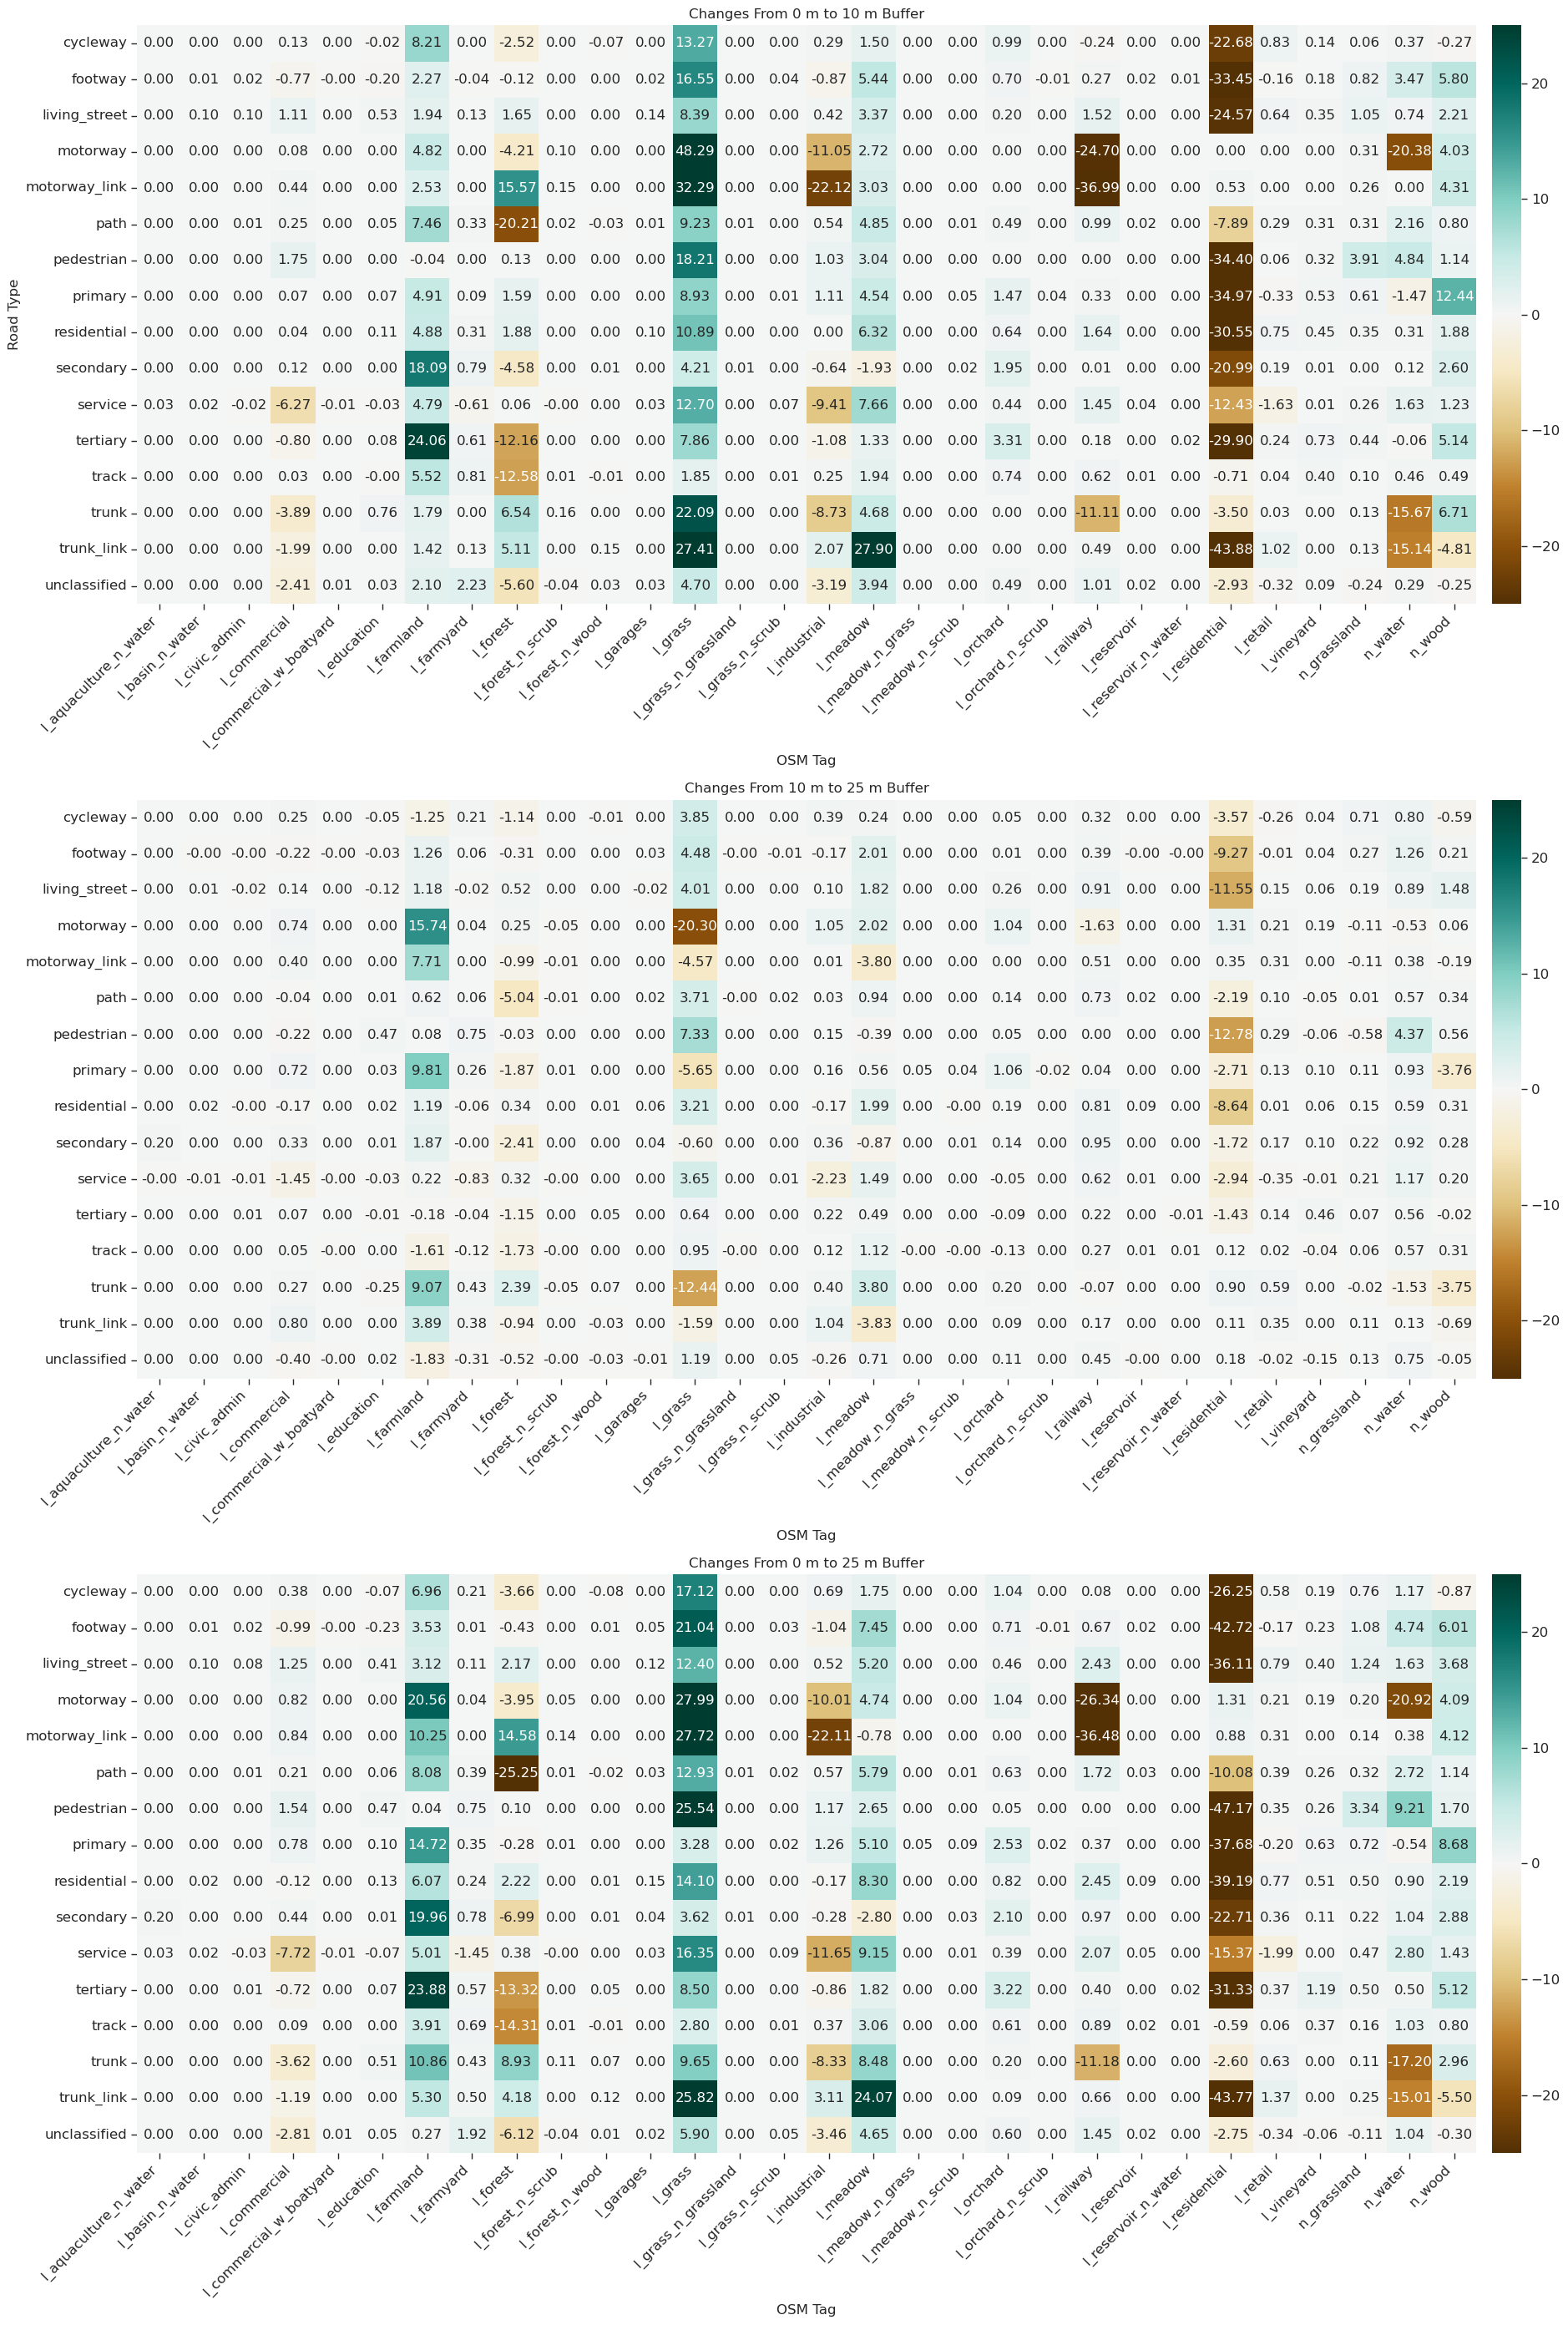

In [79]:
fig, axs = plt.subplots(3, 1, figsize=(21, 28))

vmin=-25
vmax=25

sns.heatmap(diff_0_to_10_roads, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01},  ax=axs[0])
axs[0].set_title('Changes From 0 m to 10 m Buffer')
axs[0].set_ylabel('Road Type')
axs[0].set_xlabel('OSM Tag')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(diff_10_to_25_roads, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01},  ax=axs[1])
axs[1].set_title('Changes From 10 m to 25 m Buffer')
axs[1].set_ylabel('')
axs[1].set_xlabel('OSM Tag')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(diff_0_to_25_roads, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01},  ax=axs[2])
axs[2].set_title('Changes From 0 m to 25 m Buffer')
axs[2].set_ylabel('')
axs[2].set_xlabel('OSM Tag')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')

# plt.savefig(out_dir / 'road_types_lana_horizontal_changes.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

Pearson Correlation Analysis between LULC classes (because based on road types)

In [80]:
# Calculate p-values of according correlation coefficient
def compute_p_values(df):
    # Initialize an empty DataFrame with the same columns and indices as the input
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    # Iterate over all pairs of columns
    for col1 in df.columns:
        for col2 in df.columns:
            # Compute the Pearson correlation and p-value
            _, p_value = pearsonr(df[col1], df[col2])
            # Assign the p-value to the corresponding cell in the output DataFrame
            p_values.loc[col1, col2] = p_value
    return p_values

In [81]:
# Categorize p-values and add as annotations to heatmap
def format_corr_with_pval(correlation_matrix, p_values_matrix):
    # Initialize an empty matrix with the same shape as the correlation matrix
    formatted_matrix = correlation_matrix.astype(str)
    # Iterate over the matrix elements
    for row in range(correlation_matrix.shape[0]):
        for col in range(correlation_matrix.shape[1]):
            value = correlation_matrix.iloc[row, col]
            p_value = p_values_matrix.iloc[row, col]
            # Check if comparing the same class (self-class correlation)
            if row == col:
                asterisks = ''  # No asterisks for self-class correlation
            else:
                # Determine the number of asterisks based on the p-value
                if p_value < 0.001:
                    asterisks = '***'
                elif p_value < 0.01:
                    asterisks = '**'
                elif p_value < 0.05:
                    asterisks = '*'
                else:
                    asterisks = ''
            # Format the string with the value and asterisks
            formatted_matrix.iloc[row, col] = f'{value:.2f}{asterisks}'
    return formatted_matrix

In [86]:
correlation_matrix_lana = lana_pivot_percent_roads.corr(method='pearson')
correlation_matrix_lana_10 = lana_pivot_percent_roads_10.corr(method='pearson')
correlation_matrix_lana_25 = lana_pivot_percent_roads_25.corr(method='pearson')

correlation_matrix_roads_mean = lana_pivot_percent_roads_mean.corr(method='pearson')

In [87]:
p_values_roads = compute_p_values(lana_pivot_percent_roads)
p_values_roads_10 = compute_p_values(lana_pivot_percent_roads_10)
p_values_roads_25 = compute_p_values(lana_pivot_percent_roads_25)

p_values_roads_mean = compute_p_values(lana_pivot_percent_roads_mean)

/home/grhalbgott/miniforge3/envs/lulc-ma/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [88]:
p_values_roads = p_values_roads.apply(pd.to_numeric)
p_values_roads_10 = p_values_roads_10.apply(pd.to_numeric)
p_values_roads_25 = p_values_roads_25.apply(pd.to_numeric)

p_values_roads_mean = p_values_roads_mean.apply(pd.to_numeric)

formatted_matrix_roads = format_corr_with_pval(correlation_matrix_lana, p_values_roads)
formatted_matrix_roads_10 = format_corr_with_pval(correlation_matrix_lana_10, p_values_roads_10)
formatted_matrix_roads_25 = format_corr_with_pval(correlation_matrix_lana_25, p_values_roads_25)

formatted_matrix_roads_mean = format_corr_with_pval(correlation_matrix_roads_mean, p_values_roads_mean)

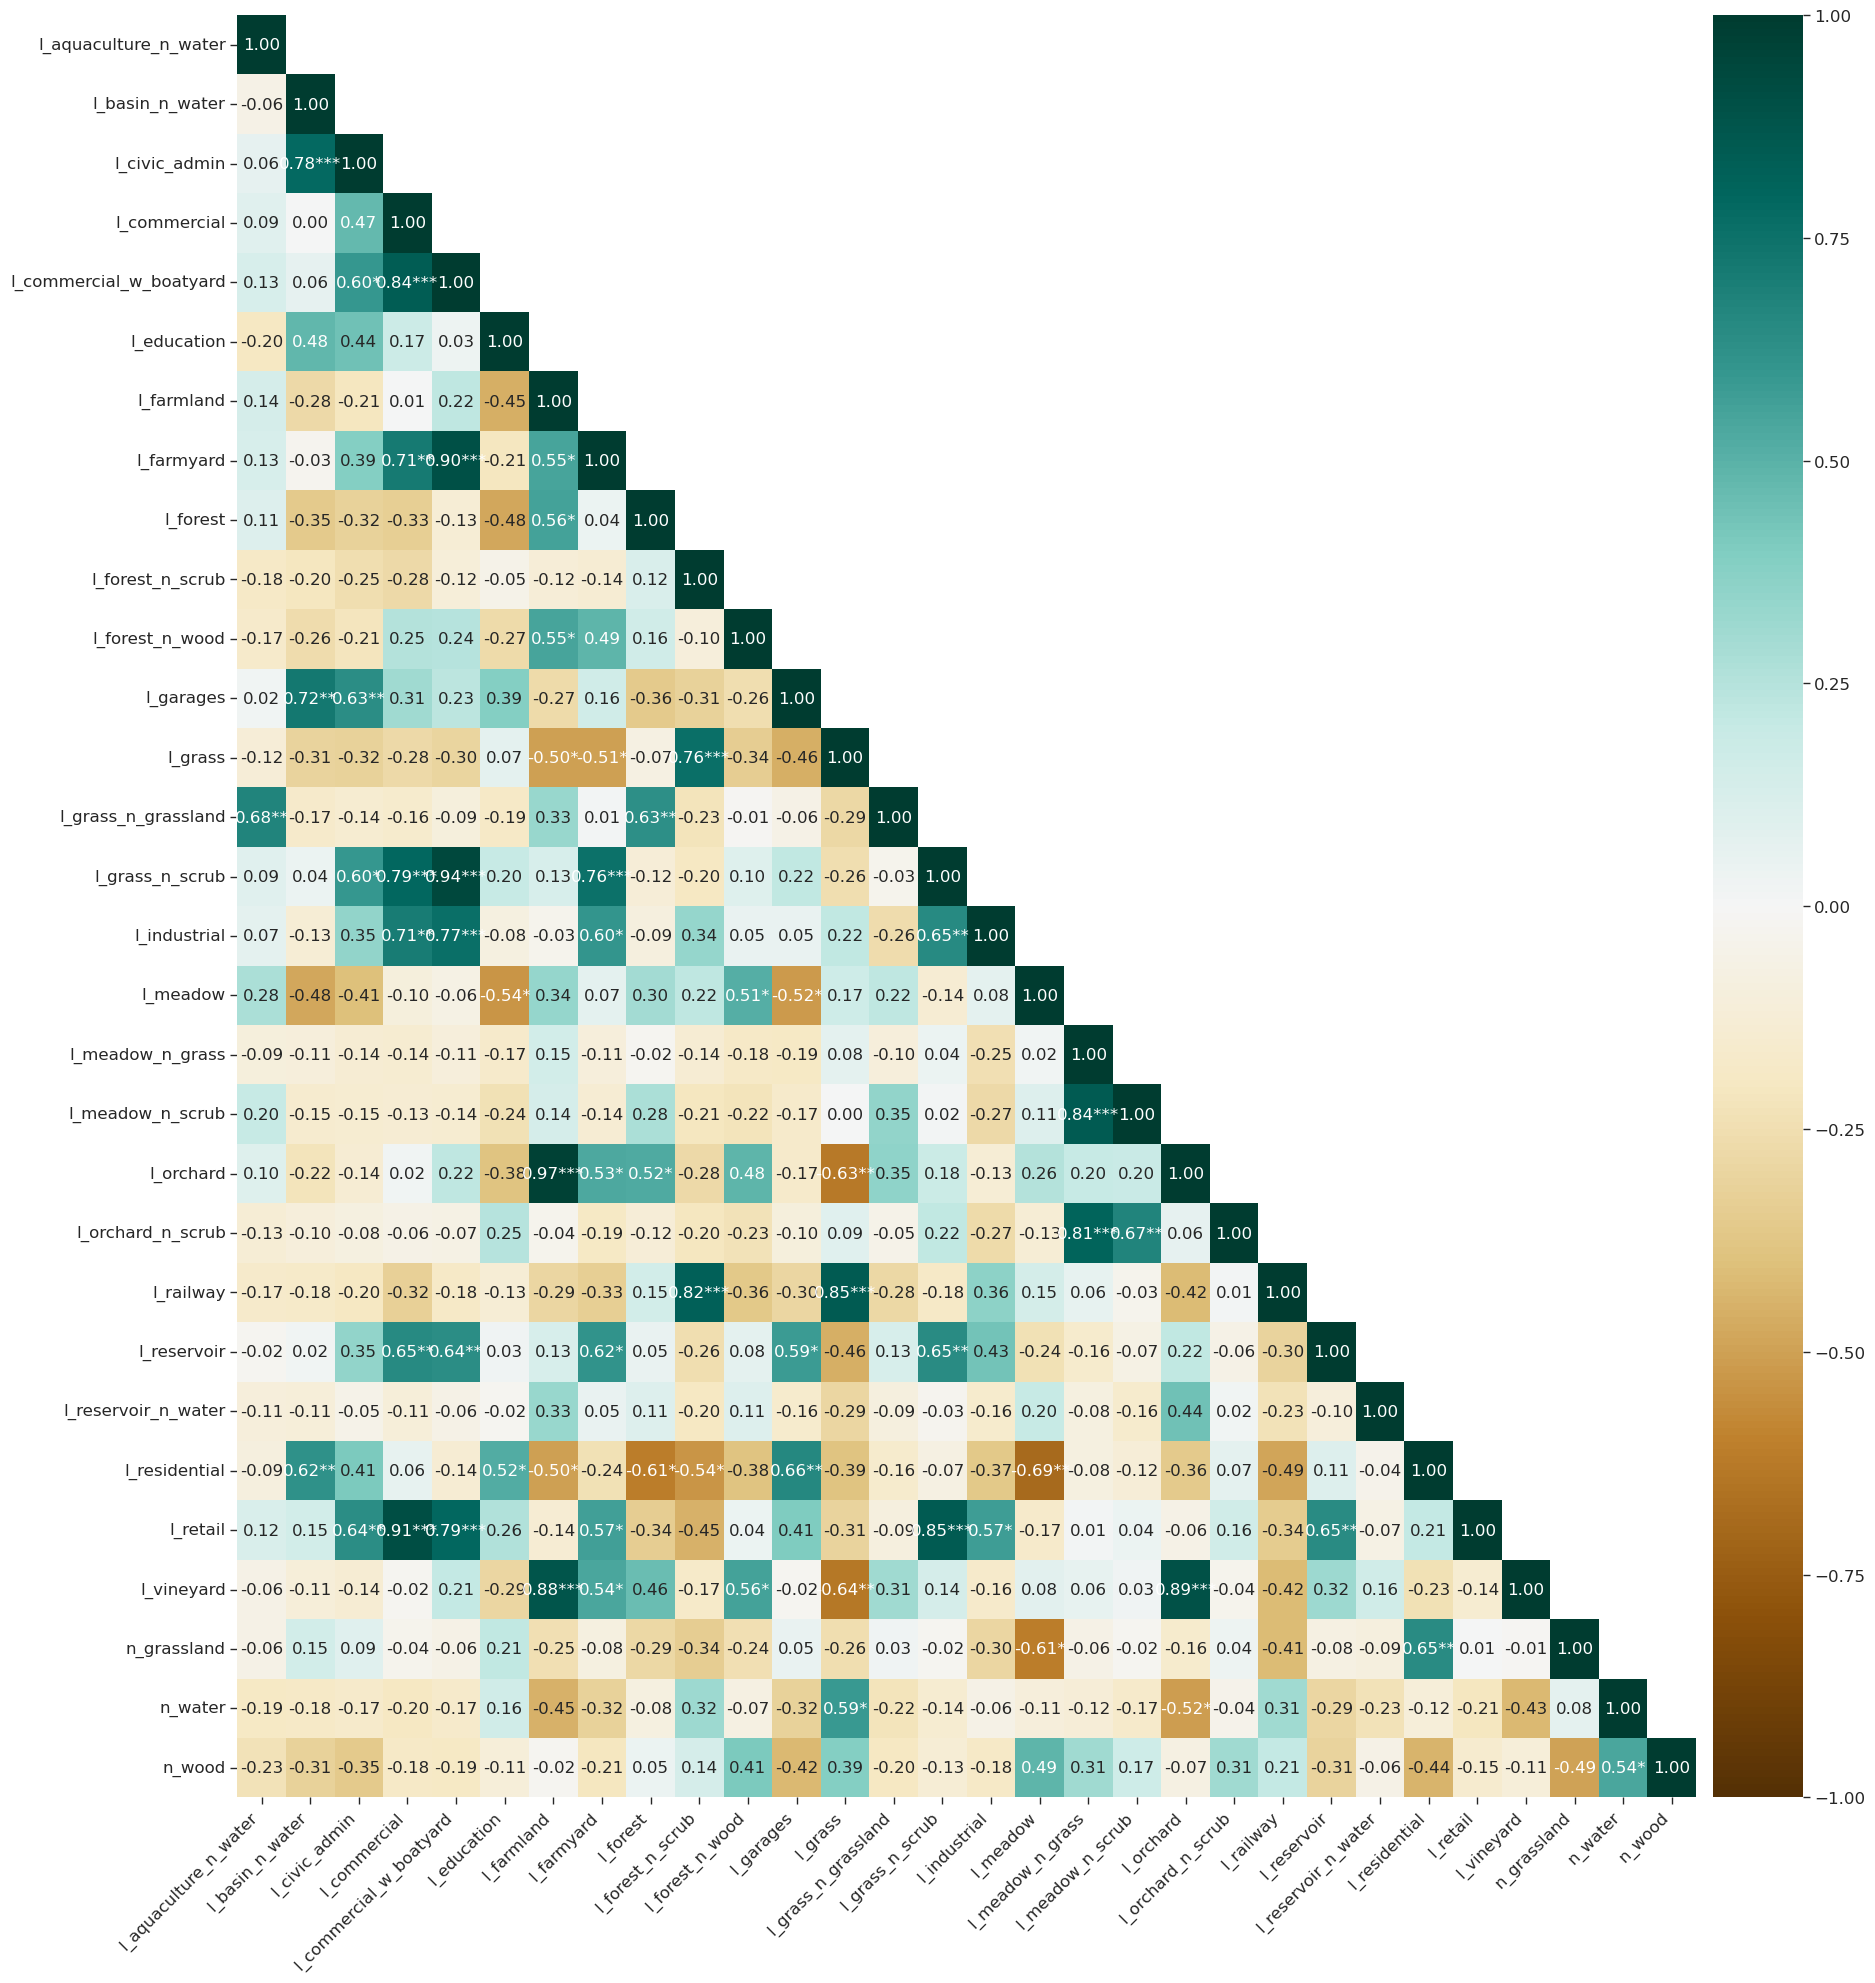

In [89]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_lana, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(20, 20))

vmin=-1
vmax=1

sns.heatmap(correlation_matrix_roads_mean, mask=mask, cmap=cmap_diverging, annot=formatted_matrix_roads_mean, fmt='', vmin=vmin, vmax=vmax, cbar_kws={'pad': 0.01}, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()